## Setting up IMC-Denoise

1. Follow the instructions under the **'Installation'** header from here: https://github.com/PENGLU-WashU/IMC_Denoise. In brief, you need to setup a new conda environment and install some packages with specific version numbers, and then clone and install the IMCDenoise package from Github.

2. Run the following command in Anaconda prompt to install a couple of extra packages we will need in the new environment: **conda install tqdm pandas seaborn**

## Imports and functions
Run this to import all the relevant packages and functions. If there is an error here, you have not setup the environment properly. It may also be possible that your graphics card / GPU is not compatible with the script. It *should* all still run, but without acceleration from the GPU, it could be *incredibly* slow!

In [218]:
import os
from os import listdir
from os.path import isfile, join, abspath, exists
from glob import glob
import tifffile as tp
import pandas as pd
import seaborn as sb
from pathlib import Path
from copy import copy
from tqdm import tqdm

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tp
from IMC_Denoise.IMC_Denoise_main.DIMR import DIMR
from IMC_Denoise.IMC_Denoise_main.DeepSNF import DeepSNF
from IMC_Denoise.DeepSNF_utils.DeepSNF_DataGenerator import DeepSNF_DataGenerator

### These are adapted from functions from IMC_Denoise

def load_single_img(filename):
    
    """
    Loading single image from directory.
    Parameters
    ----------
    filename : The image file name, must end with .tiff.
        DESCRIPTION.
    Returns
    -------
    Img_in : int or float
        Loaded image data.
    """
    if filename.endswith('.tiff') or filename.endswith('.tif'):
        Img_in = tp.imread(filename).astype('float32')
    else:
        raise ValueError('Raw file should end with tiff or tif!')
    if Img_in.ndim != 2:
        raise ValueError('Single image should be 2d!')
    return Img_in

def load_imgs_from_directory(load_directory,channel_name,quiet=False):
    Img_collect = []
    img_folders = glob(join(load_directory, "*", ""))
    Img_file_list=[]

    if not quiet:
        print('Image data loaded from ...\n')
    
    for sub_img_folder in img_folders:
        Img_list = [f for f in listdir(sub_img_folder) if isfile(join(sub_img_folder, f)) & (f.endswith(".tiff") or f.endswith(".tif"))]
        for Img_file in Img_list:
            if channel_name.lower() in Img_file.lower():
                Img_read = load_single_img(sub_img_folder + Img_file)
                
                if not quiet:
                    print(sub_img_folder + Img_file)
                
                Img_file_list.append(Img_file)
                Img_collect.append(Img_read)
                break

    if not quiet:
        print('\n' + 'Image data loaded completed!')
    
    if not Img_collect:
        print(f'No such channel as {channel_name}. Please check the channel name again!')
        return

    return Img_collect, Img_file_list, img_folders


### This is for doing QC heatmaps and PCAs to look for outliers

def qc_heatmap(directory='tiffs',
                quantile=0.95,
                save=True,
                channels_list=channel_df['channel'].tolist(),
                normalize=True,
                figsize=(20,10),
                dpi=200,             
                save_dir='qc_images',
                do_PCA=True,
                annotate_PCA=True,
              hide_figures=False):

    # Create folder for saving
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True)
    
    # Create lists to save data into
    channel_list=[]
    roi_list=[]
    img_max_list=[]
    img_mean_list=[]
    img_std_list=[]
    img_q_list=[]

    
    print('Extracting data from images...\n')
    for channel in tqdm(channels_list):

        Img_collect, Img_file_list, img_folders = load_imgs_from_directory(directory, channel, quiet=True)    

        for img,img_f in zip(Img_collect,img_folders):
            roi = Path(img_f).parts[1]
            img_max=np.max(img)
            img_mean=np.mean(img)
            img_std=np.std(img)
            img_q=np.quantile(img,quantile)

            channel_list.append(copy(channel))
            roi_list.append(copy(roi))
            img_max_list.append(copy(img_max))
            img_mean_list.append(copy(img_mean))
            img_std_list.append(copy(img_std))
            img_q_list.append(copy(img_q))


    results_df = pd.DataFrame(list(zip(channel_list, roi_list, img_max_list, img_mean_list, img_std_list, img_q_list)), columns=['channel','ROI','max','mean', 'std','quantile'])

    print('Plotting results...\n')

    for i in ['max','mean','quantile', 'std','quantile']:
        results_pivot = pd.pivot_table(results_df, index='channel',columns='ROI', values=i)

        if normalize:
            results_pivot = results_pivot.div(results_pivot.max(axis=1), axis=0)
            i = i+'_normalised'

        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        ax = sb.heatmap(results_pivot,xticklabels=True, yticklabels=True)
        plt.title(i)

        if save:
            fig.savefig(join(save_dir,f'{directory}_{i}_heatmap.png'))
        
        if hide_figures:
            plt.close()
                        
        if do_PCA:
            import sklearn
            from sklearn.decomposition import PCA

            scaled_summary_data = sklearn.preprocessing.StandardScaler().fit_transform(results_pivot.T)

            pca = PCA(n_components=2)
            embedding = pca.fit_transform(scaled_summary_data)

            #Create the graphs
            fig, ax = plt.subplots(figsize=(10,10))
            ax.scatter(
                embedding[:, 0],
                embedding[:, 1],
                s=15)
            
            if annotate_PCA:
                for loc, txt in zip(embedding,list(range(len(results_pivot.T.index)))):
                    ax.annotate(txt, loc)  
                pd.DataFrame(results_pivot.T.index).to_csv(join(save_dir,'roi_annotations.csv'))                    
            
            fig.gca().set_aspect('equal', 'datalim')
            ax.set_xlabel('PCA1')
            ax.set_ylabel('PCA2')
            plt.title(i)
            
            if save:
                plt.savefig(join(save_dir,f'{directory}_{i}_PCA.png'))
                
            if hide_figures:
                plt.close()

#### Deep SNF batch function            
            
def deep_SNF_batch(raw_directory = "tiffs",
                   processed_output_dir = "processed",
                   process_all_channels = True,
                   specific_channels = [],
                   patch_step_size=60,
                   train_epoches = 50, # 50 gets good results in my experience.
                    train_initial_lr = 1e-3, # inital learning rate. The default is 1e-3.
                    train_batch_size = 128, # training batch size. For a GPU with smaller memory, it can be tuned smaller. The default is 256.
                    pixel_mask_percent = 0.2, # percentage of the masked pixels in each patch. The default is 0.2.
                    val_set_percent = 0.15, #percentage of validation set. The default is 0.15.
                    loss_function = "I_divergence", # loss function used. The default is "I_divergence".
                    loss_name = None, # training and validation losses saved here, either .mat or .npz format. If not defined, the losses will not be saved.
                    weights_save_directory = None, # location where 'weights_name' and 'loss_name' saved.
                    # If the value is None, the files will be saved in a sub-directory named "trained_weights" of  the current file folder.
                    is_load_weights = False, # Use the trained model directly. Will not read from saved one.
                    lambda_HF = 3e-6): # HF regularization parameter

    # Error catching to make specific channels a list if just one channel given
    if not isinstance(specific_channels, list):
        specific_channels=[specific_channels]
    
    #################################################
    ######  Deep SNF settings
    #################################################
    train_epoches = 50 # training epoches, which should be about 200 for a good training result. The default is 200.
    train_initial_lr = 1e-3 # inital learning rate. The default is 1e-3.
    train_batch_size = 128 # training batch size. For a GPU with smaller memory, it can be tuned smaller. The default is 256.
    pixel_mask_percent = 0.2 # percentage of the masked pixels in each patch. The default is 0.2.
    val_set_percent = 0.15 #percentage of validation set. The default is 0.15.
    loss_function = "I_divergence" # loss function used. The default is "I_divergence".
    loss_name = None # training and validation losses saved here, either .mat or .npz format. If not defined, the losses will not be saved.
    weights_save_directory = None # location where 'weights_name' and 'loss_name' saved.
    # If the value is None, the files will be saved in a sub-directory named "trained_weights" of  the current file folder.
    is_load_weights = False # Use the trained model directly. Will not read from saved one.
    lambda_HF = 3e-6 # HF regularization parameter


    # Training settings
    row_step=patch_step_size
    col_step=patch_step_size 

    # Create folders
    processed_output_dir = Path(processed_output_dir)
    processed_output_dir.mkdir(exist_ok=True)

    # Error catching lists
    error_channels=[]
    completed_channels=[]

    if process_all_channels:
        channels = channel_df['channel'].tolist()
    else:
        channels = specific_channels


    n = len(channels)
    print(f'\nPerforming denoising on the following {n} channels... \n')
    print(channels)
    
        
    for channel_name in tqdm(channels):

        try:

            #if 'generated_patches' in globals():
            #    del globals.generated_patches    

            DataGenerator = DeepSNF_DataGenerator(channel_name = channel_name, 
                                                  n_neighbours = 4, # Larger n enables removing more consecutive hot pixels 
                                                  n_iter = 3, # Iteration number for DIMR
                                                  window_size = 3, # Slide window size. For IMC images, window_size = 3 is fine.
                                                  col_step=col_step,
                                                  row_step=row_step)

            generated_patches = DataGenerator.generate_patches_from_directory(load_directory = raw_directory)
            print('The shape of the generated training set is ' + str(generated_patches.shape) + '.')

            deepsnf = DeepSNF(train_epoches = train_epoches, 
                              train_learning_rate = train_initial_lr,
                              train_batch_size = train_batch_size,
                              mask_perc_pix = pixel_mask_percent,
                              val_perc = val_set_percent,
                              loss_func = loss_function,
                              weights_name = "weights_"+str(channel_name)+".hdf5",
                              loss_name = loss_name,
                              weights_dir = weights_save_directory, 
                              is_load_weights = is_load_weights,
                              lambda_HF = lambda_HF)

            print('STARTING TRAINING...')
            # Train the DeepSNF classifier 
            train_loss, val_loss = deepsnf.train(generated_patches)

            # Load all images
            Img_collect, Img_file_list, img_folders = load_imgs_from_directory(raw_directory, channel_name)

            # Save resulting images
            for i, img_file_name, folder in zip(Img_collect, Img_file_list, img_folders):

                #Perform both the hot pixel and shot noise 
                Img_DIMR_DeepSNF = deepsnf.perform_IMC_Denoise(i, n_neighbours = n_neighbours, n_iter = n_iter, window_size = window_size)

                #Gets the ROI folder name from the path
                roi_folder_name = Path(folder).parts[1]

                #Makes sure the output folder name exists for this ROI
                Path(join(processed_output_dir, roi_folder_name)).mkdir(exist_ok=True) 

                #The output file is named the same as the input file
                save_path = join(processed_output_dir, roi_folder_name, img_file_name)      

                #Save the denoised file
                tp.imsave(save_path,Img_DIMR_DeepSNF.astype('float32'))

            completed_channels.append(channel_name)
        except Exception as e:

            print(f"Error in channel {channel_name}: {Exception}: {e}")
            error_channels.append(f"{channel_name}: {Exception}: {e}")

    print("Successfull with channels:")
    print(completed_channels)
    print("Channels with errors:")
    print(error_channels)
    deep_SNF_batch.completed = completed_channels
    deep_SNF_batch.errors = error_channels
    
# Side by side comparisson of before and after processing
    
def qc_check_side_by_side(channels=[],
            colourmap ='jet',
            dpi=200,
            save=True,
            save_dir='qc_images',
            do_all_channels=True,
            hide_images=True,
            raw_directory='tiffs',
            processed_output_dir='processed',
            quiet=True):
    
    if not isinstance(channels, list):
        channels=[channels]    
    
    # Create folders
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True)

    if do_all_channels:
        channel_list=all_data_channels
    else:
        channel_list=channels

    # Error catching lists
    error_channels=[]
    completed_channels=[]    

    for channel_name in channel_list:

        try:

            raw_Img_collect, raw_Img_file_list, raw_img_folders = load_imgs_from_directory(raw_directory, channel_name,quiet=quiet)
            pro_Img_collect, pro_Img_file_list, pro_img_folders = load_imgs_from_directory(processed_output_dir, channel_name,quiet=quiet)

            fig, axs = plt.subplots(len(raw_Img_collect), 2, figsize=(10, 5*len(raw_Img_collect)), dpi=dpi)

            count = 0
            for r_img,p_img in zip(raw_Img_collect,pro_Img_collect):
                im1= axs.flat[count].imshow(r_img, vmin = 0, vmax = 0.5*np.max(r_img), cmap = colourmap)
                divider = make_axes_locatable(axs.flat[count])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                fig.colorbar(im1, cax=cax, orientation='vertical')    
                count=count+1

                im2 = axs.flat[count].imshow(p_img, vmin = 0, vmax = 0.5*np.max(p_img), cmap = colourmap)
                divider = make_axes_locatable(axs.flat[count])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                fig.colorbar(im2, cax=cax, orientation='vertical')    
                count=count+1 

            fig.savefig(join(save_dir, channel_name+'.png'))

            if hide_images:
                plt.close()

            completed_channels.append(channel_name)

        except Exception as e:

            print(f"Error in channel {channel_name}: {Exception}: {e}")
            error_channels.append(f"{channel_name}: {Exception}: {e}")

    print("Successfull with channels:")
    print(completed_channels)
    print("Channels with errors:")
    print(error_channels)
    qc_check_side_by_side.completed = completed_channels
    qc_check_side_by_side.errors = error_channels        
    
    
# Function to reassemble TIFF stacks

def reassemble_stacks(restack_input_folder = 'tiffs',
                      restacked_output_folder = 'tiffs_restacked')

    # Make output directories if they don't exisit
    restack_input_folder = Path(restack_input_folder)
    output = Path(restacked_output_folder)
    output.mkdir(exist_ok=True)

    # Get a list of paths of ROI folder
    Img_folders = glob(join(restack_input_folder, "*", ""))

    print('Savings stacks...')
    for i in tqdm(Img_folders):

        tiff_files = list(Path(i).rglob('*.tiff'))

        image_stack=[]

        for file in tiff_files:
            im = tp.imread(str(file)).astype('float32')
            image_stack.append(im)

        image_stack = np.asarray(image_stack)

        save_path=join(restacked_output_folder, Path(i).parts[1]+".tiff")

        tp.imsave(save_path,image_stack.astype('float32'))



## GPU Test

This should return 'True' and the name of your GPU. If it doesn't, something has gone wrong in the setup of TensorFlow and/or CUDA that allows GPU-acceleration. Without it, the script will run *incredibly* low

In [34]:
import tensorflow as tf

if tf.test.is_built_with_cuda()==True:
    print('GPU accceleration enabled')
    print(tf.config.list_physical_devices('GPU'))
else:
    print('GPU not found! Check TensorFlow and CUDA setup')

GPU accceleration enabled
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Unpack tiff stacks

<font color='red'>input_folder </font> = The folder where the stacked tiff files are. You should be able to just copy and paste the whole .ome.tiff folder that the Bodenmiller pipeline creates after it has extracted the tiff files from the MCD files. This folde also contains the .csv panel files, copy those too! Any panorama files will also be in the same folder, but they won't be used here.

<font color='red'>unstacked_output_folder </font> = Where the 'unstacked' tiff files will be stored. They will be unpacked into a single folder per ROI.

<font color='red'>use_panel_files </font> = If you are using the Bodenmiller pipeline, leave this as True. It will use the .csv panel files for each ROI to properly label the unpacked channels with their metal tags and antigen targets, and will create a file called <font color='blue'>ROI_data.csv</font> which will store all the information

In [202]:
# The folder containing the 
input_folder = 'tiff_stacks' 
unstacked_output_folder = 'tiffs'
use_panel_files=True

#################################################
#################################################

# Make output directories if they don't exist
input_folder = Path(input_folder)
output = Path(unstacked_output_folder)
output.mkdir(exist_ok=True)

# Setup a blank dataframe ready to add to
if use_panel_files:
    #roi_data = pd.DataFrame(columns=['panel_filename','channel_name','channel_label','filename','folder','fullstack_path'])
    roi_data = pd.DataFrame(columns=['channel_name','channel_label'])
# Get a list of all the .tiff files in the input directory
tiff_files = list(input_folder.rglob('*.tiff'))

print('Unpacking ROIs...')
for roi_count,i in enumerate(tqdm(tiff_files)):
    
    image = tp.imread(str(i))    

    folder_name = os.path.splitext(os.path.basename(i))[0]

    tiff_folder_name = os.path.splitext(os.path.basename(i))[0]    
    output_dir = Path(unstacked_output_folder,tiff_folder_name)
    output_dir.mkdir(exist_ok=True)        
    
    if use_panel_files:

        panel_filename = os.path.splitext(os.path.splitext(os.path.basename(i))[0])[0] + '.csv'
        panel_path = join(*i.parts[0:-1])
        panel_df = pd.read_csv(join(panel_path, panel_filename))
        panel_df['fullstack_path'] = copy(str(i))       
        panel_df['panel_filename']=panel_filename
        panel_df['folder']=folder_name
        roi_data = pd.concat([roi_data, panel_df], sort=True)
    
    for channel_count in range(image.shape[0]):
        
        if use_panel_files:
            
            panel_df['filename']=copy(str(channel_count)).zfill(2)+"_"+str(roi_count).zfill(2)+"_"+panel_df['channel_name']+"_"+panel_df['channel_label'].astype(str)+".tiff"
            tp.imwrite(join(output_dir, panel_df.loc[channel_count,'filename']), image[channel_count])
        else:
            file_name=copy(str(channel_count)).zfill(2)+"_"+str(roi_count).zfill(2)+".tiff"
            tp.imwrite(join(output_dir, file_name), image[channel_count])        
        
if use_panel_files:
    roi_data.to_csv('ROI_data.csv')       
    all_data_channels = roi_data.dropna().channel_label.unique().tolist()
    all_data_channel_names = roi_data.dropna().channel_name.unique().tolist()
    channel_df = pd.DataFrame(list(zip(all_data_channel_names,all_data_channels)), columns = ['channel_name', 'channel_label'])
    channel_df['channel']=channel_df['channel_name'] + "_" + channel_df['channel_label']
    channel_df.to_csv('channels_list.csv')
    
    blank_channels = roi_data[roi_data.channel_label.isna()].channel_name.unique()
    n = len(blank_channels)
    print(f'The following {n} EMPTY channels were detected, and will be NOT be processed... \n')
    print(roi_data[roi_data.channel_label.isna()].channel_name.unique().tolist())
    
    n = len(all_data_channels)
    print(f'\nThe following {n} channels were detected, and will be used if process_all_channels=True in the next step... \n')
    print(channel_df['channel'])

Unpacking ROIs...


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:58<00:00,  1.62it/s]

The following 10 EMPTY channels were detected, and will be NOT be processed... 

['ArAr80', 'Ag107', 'Ag109', 'In113', 'Xe131', 'Xe134', 'Ba138', 'Gd157', 'Pt194', 'Pb208']

The following 43 channels were detected, and will be used if process_all_channels=True in the next step... 

0                  Y89_SMA
1               In115_Iba1
2     La139_PanCytokeratin
3              Pr141_S100B
4               Nd142_MHCI
5           Nd143_Vimentin
6               Nd144_CD14
7              Nd145_ICAM1
8               Nd146_CD16
9               Sm147_PD-1
10            Nd148_SOX-10
11             Sm149_CD11b
12              Nd150_CD44
13         Eu151_GranzymeB
14              Sm152_CD45
15              Eu153_CD31
16             Sm154_CD11c
17             Gd155_HIF1a
18               Gd156_CD4
19            Gd158_CD45RA
20               Tb159_vWF
21             Gd160_FOXP3
22             Dy161_TIM-3
23             Dy162_CD206
24             Dy163_GLUT1
25             Dy164_AGTR1
26            H

## 2. QC check on raw data

Extracting data from images...



100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [02:16<00:00,  3.18s/it]


Plotting results...



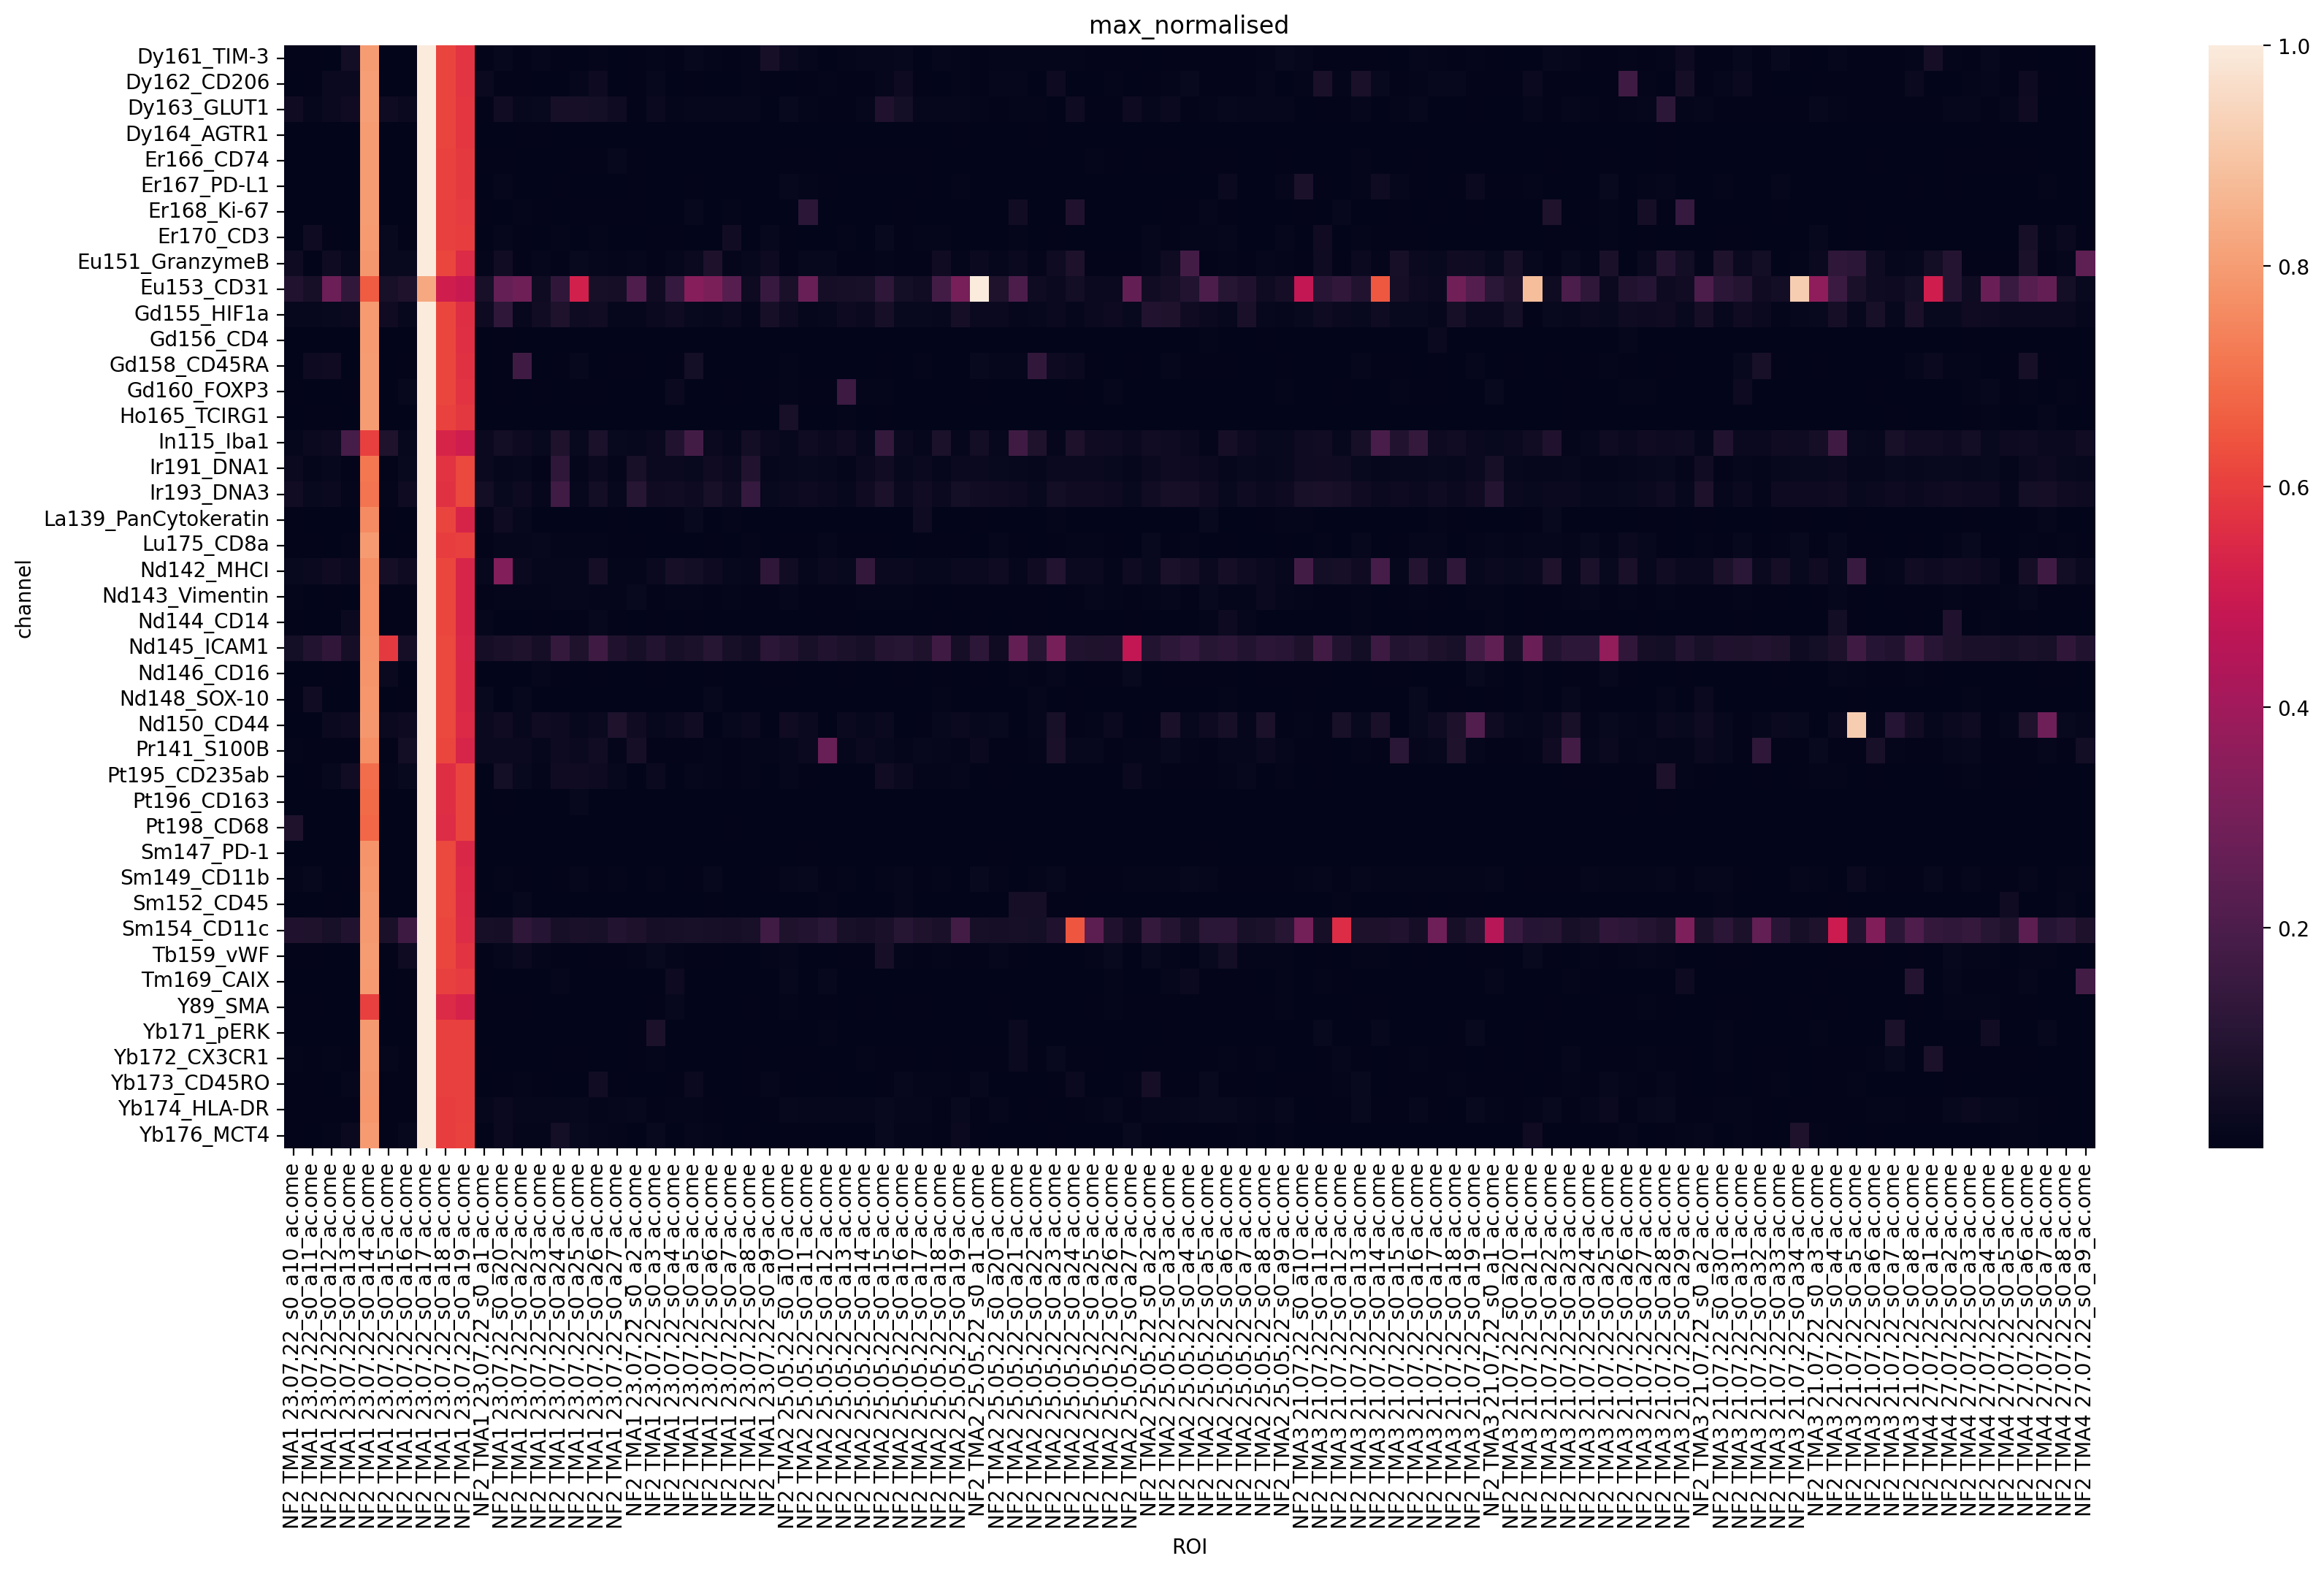

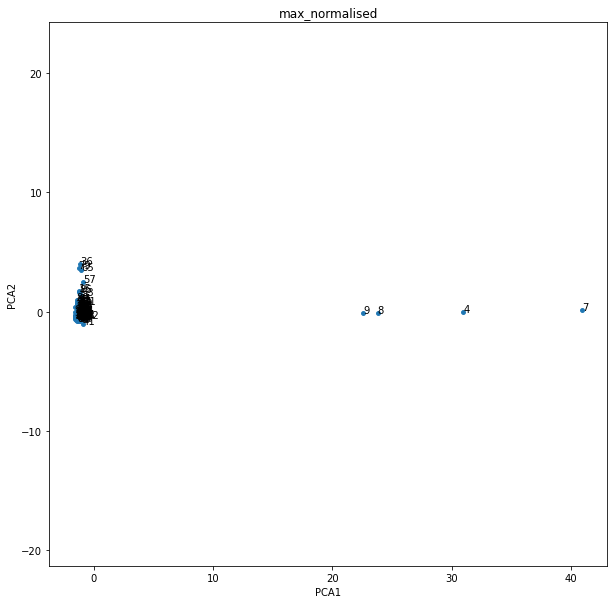

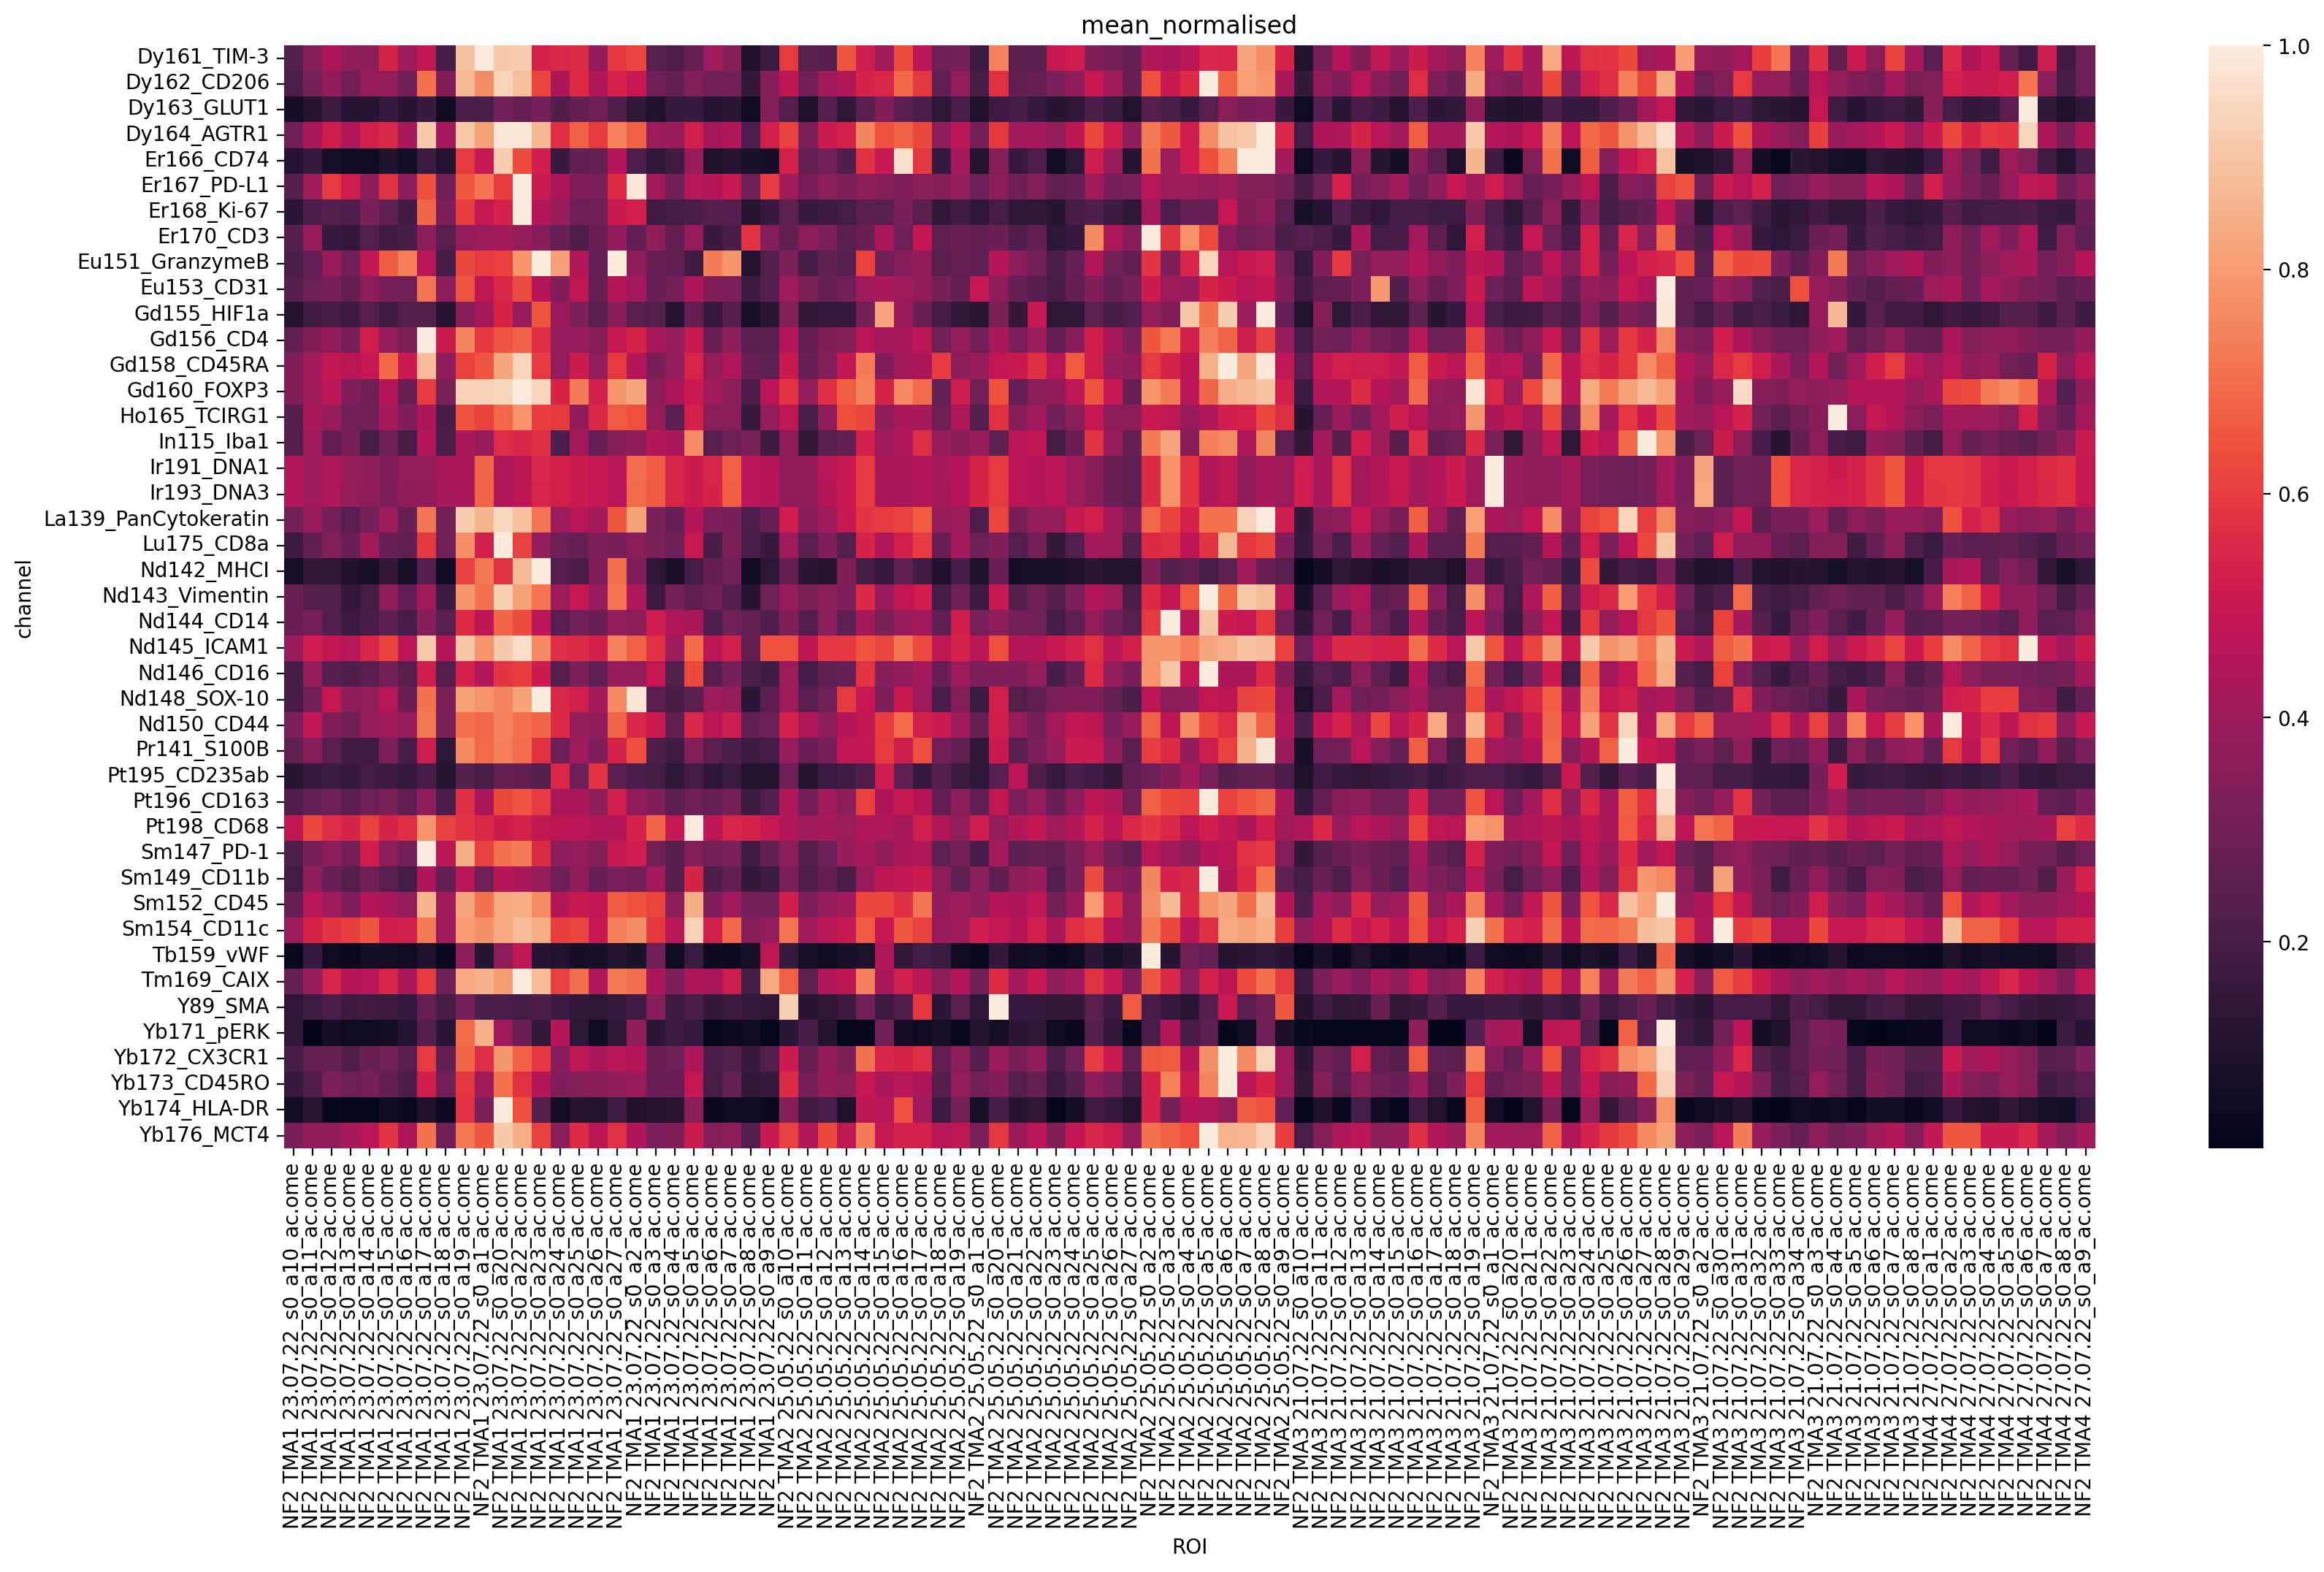

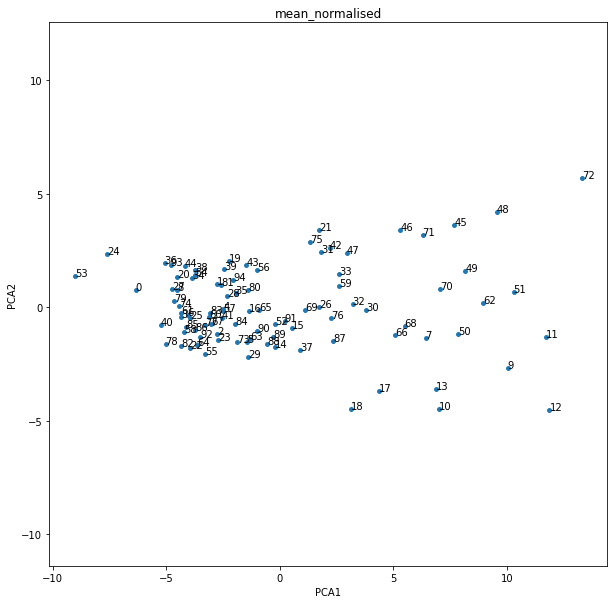

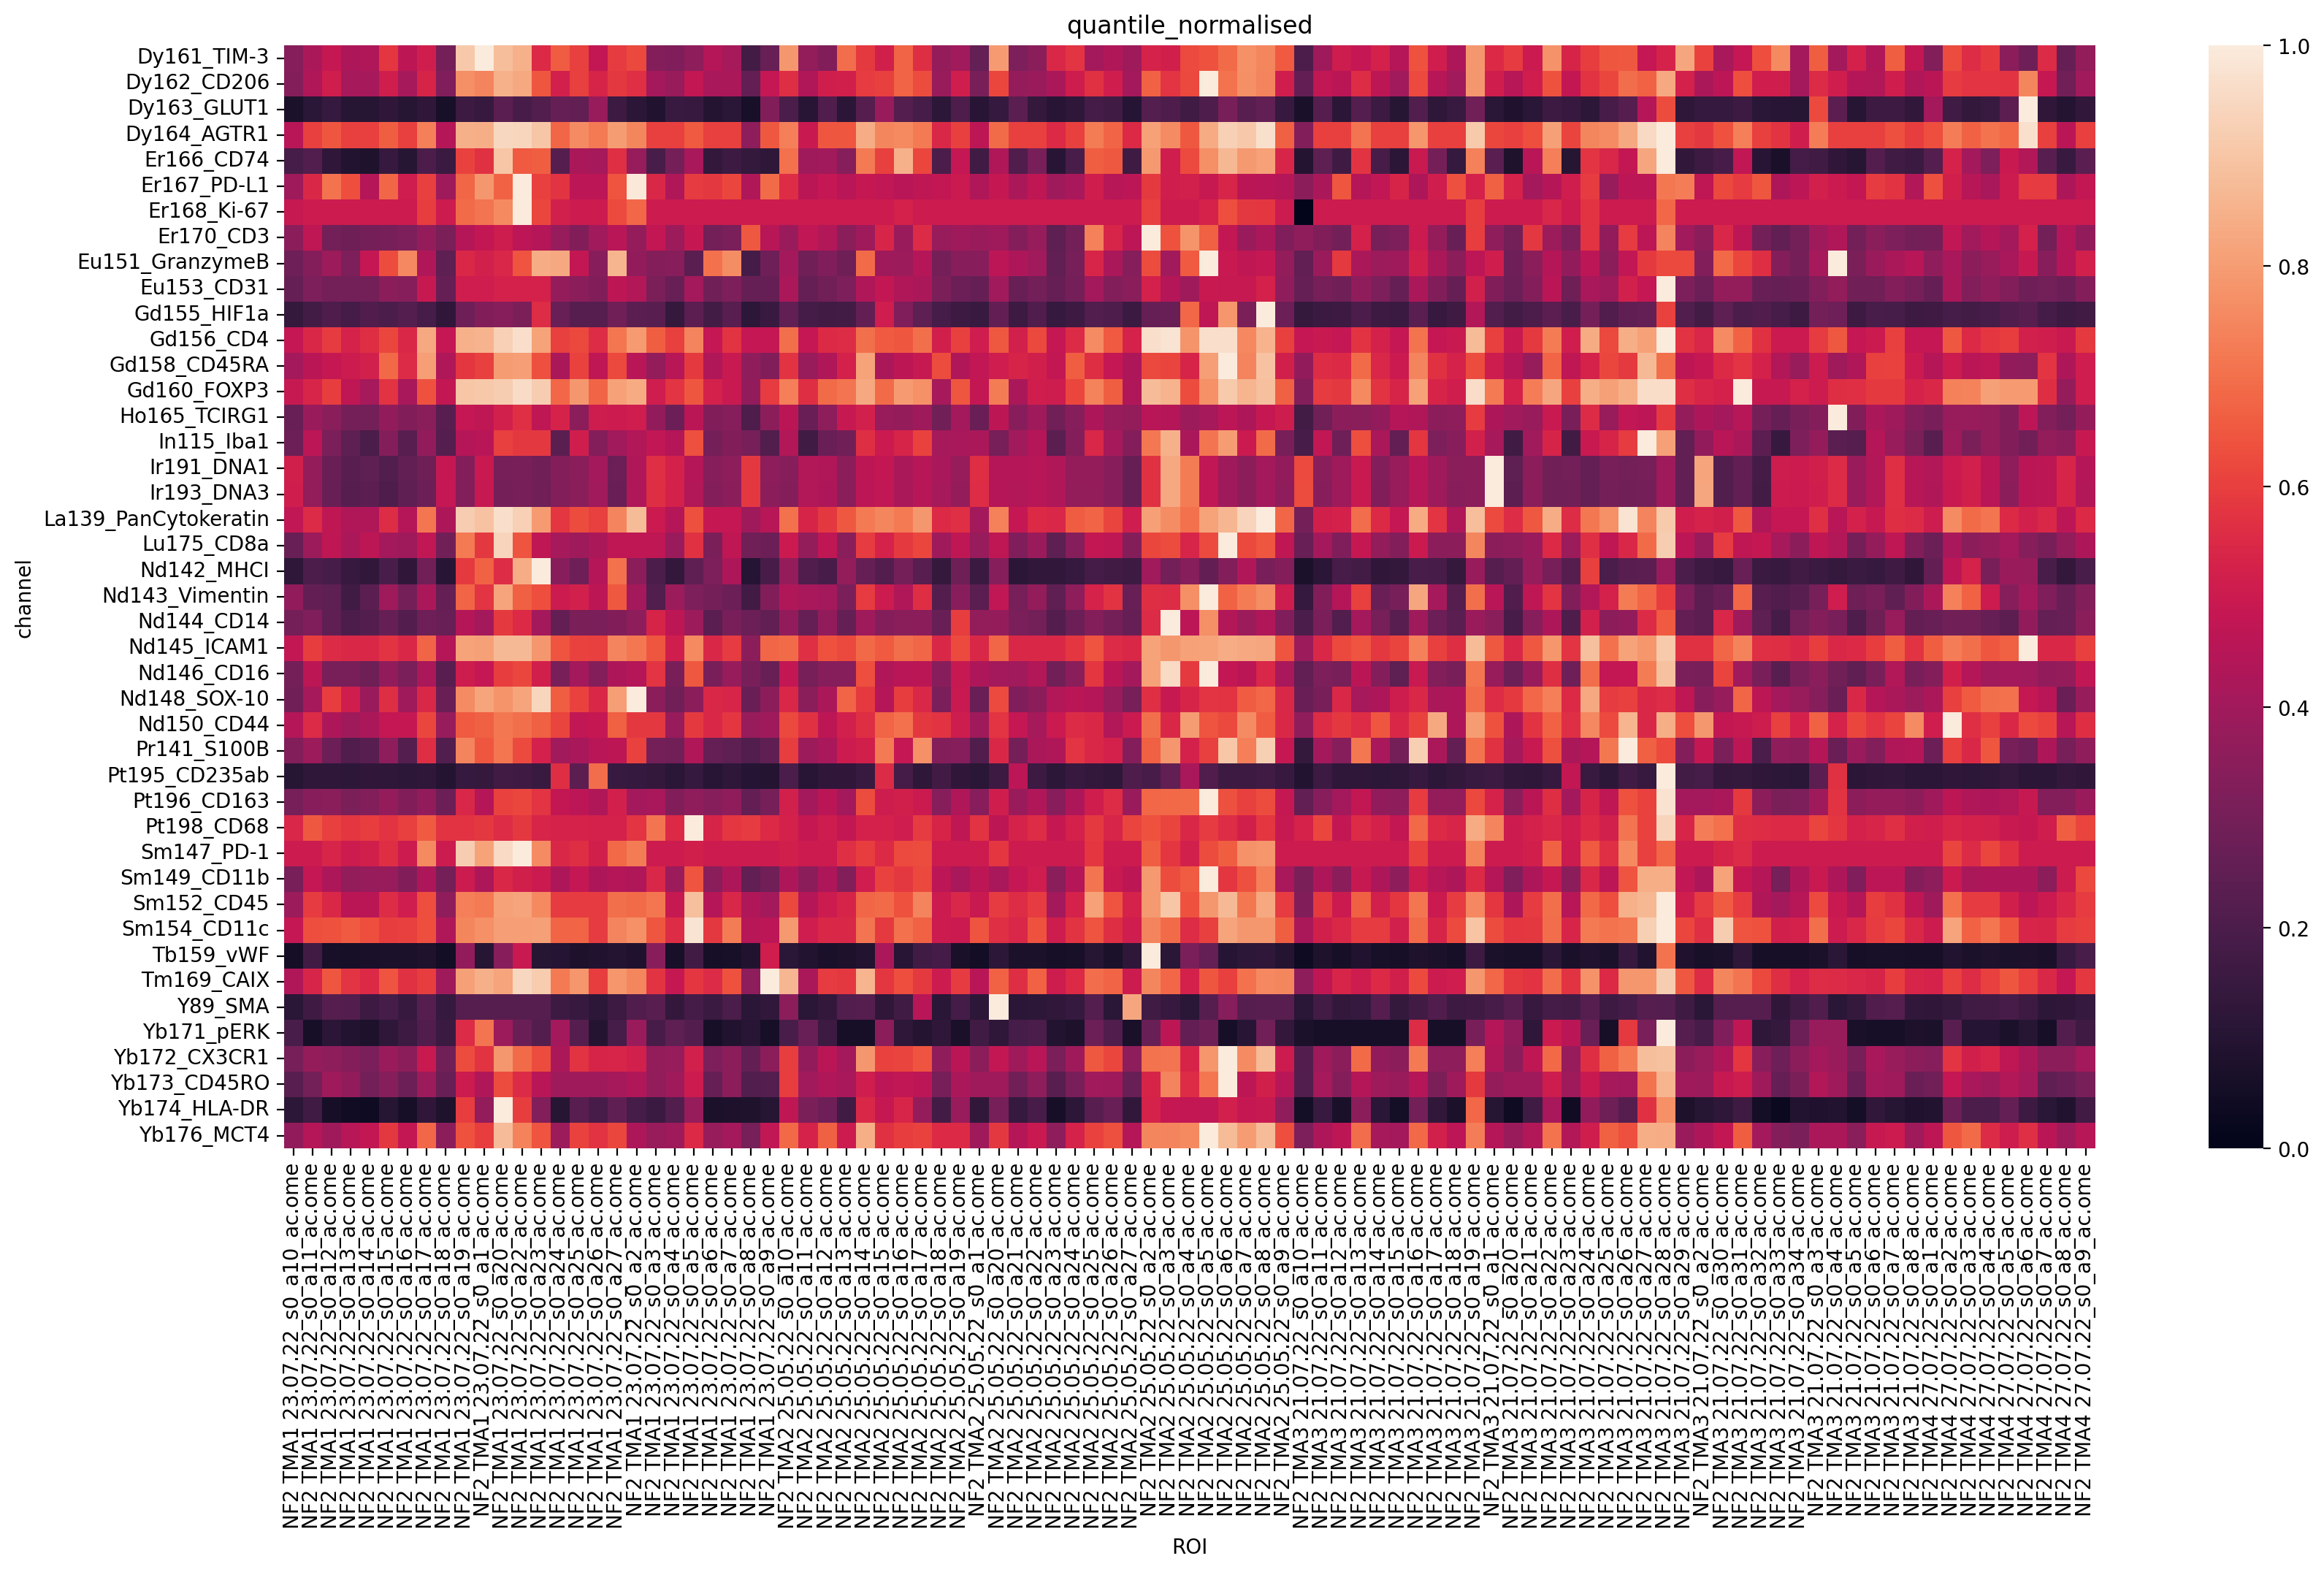

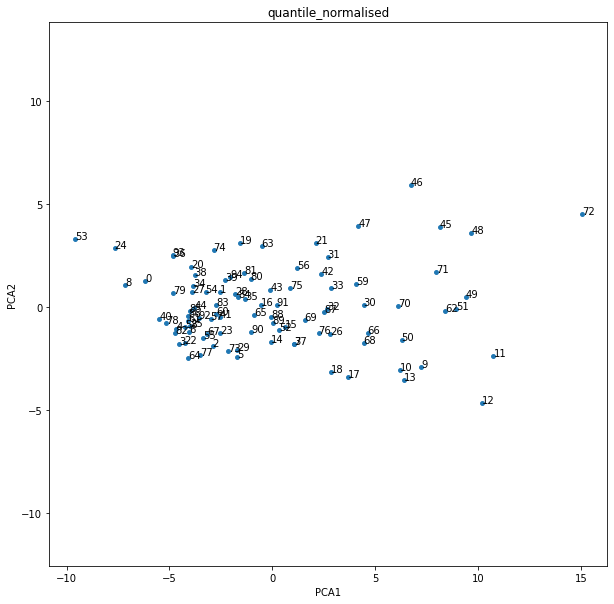

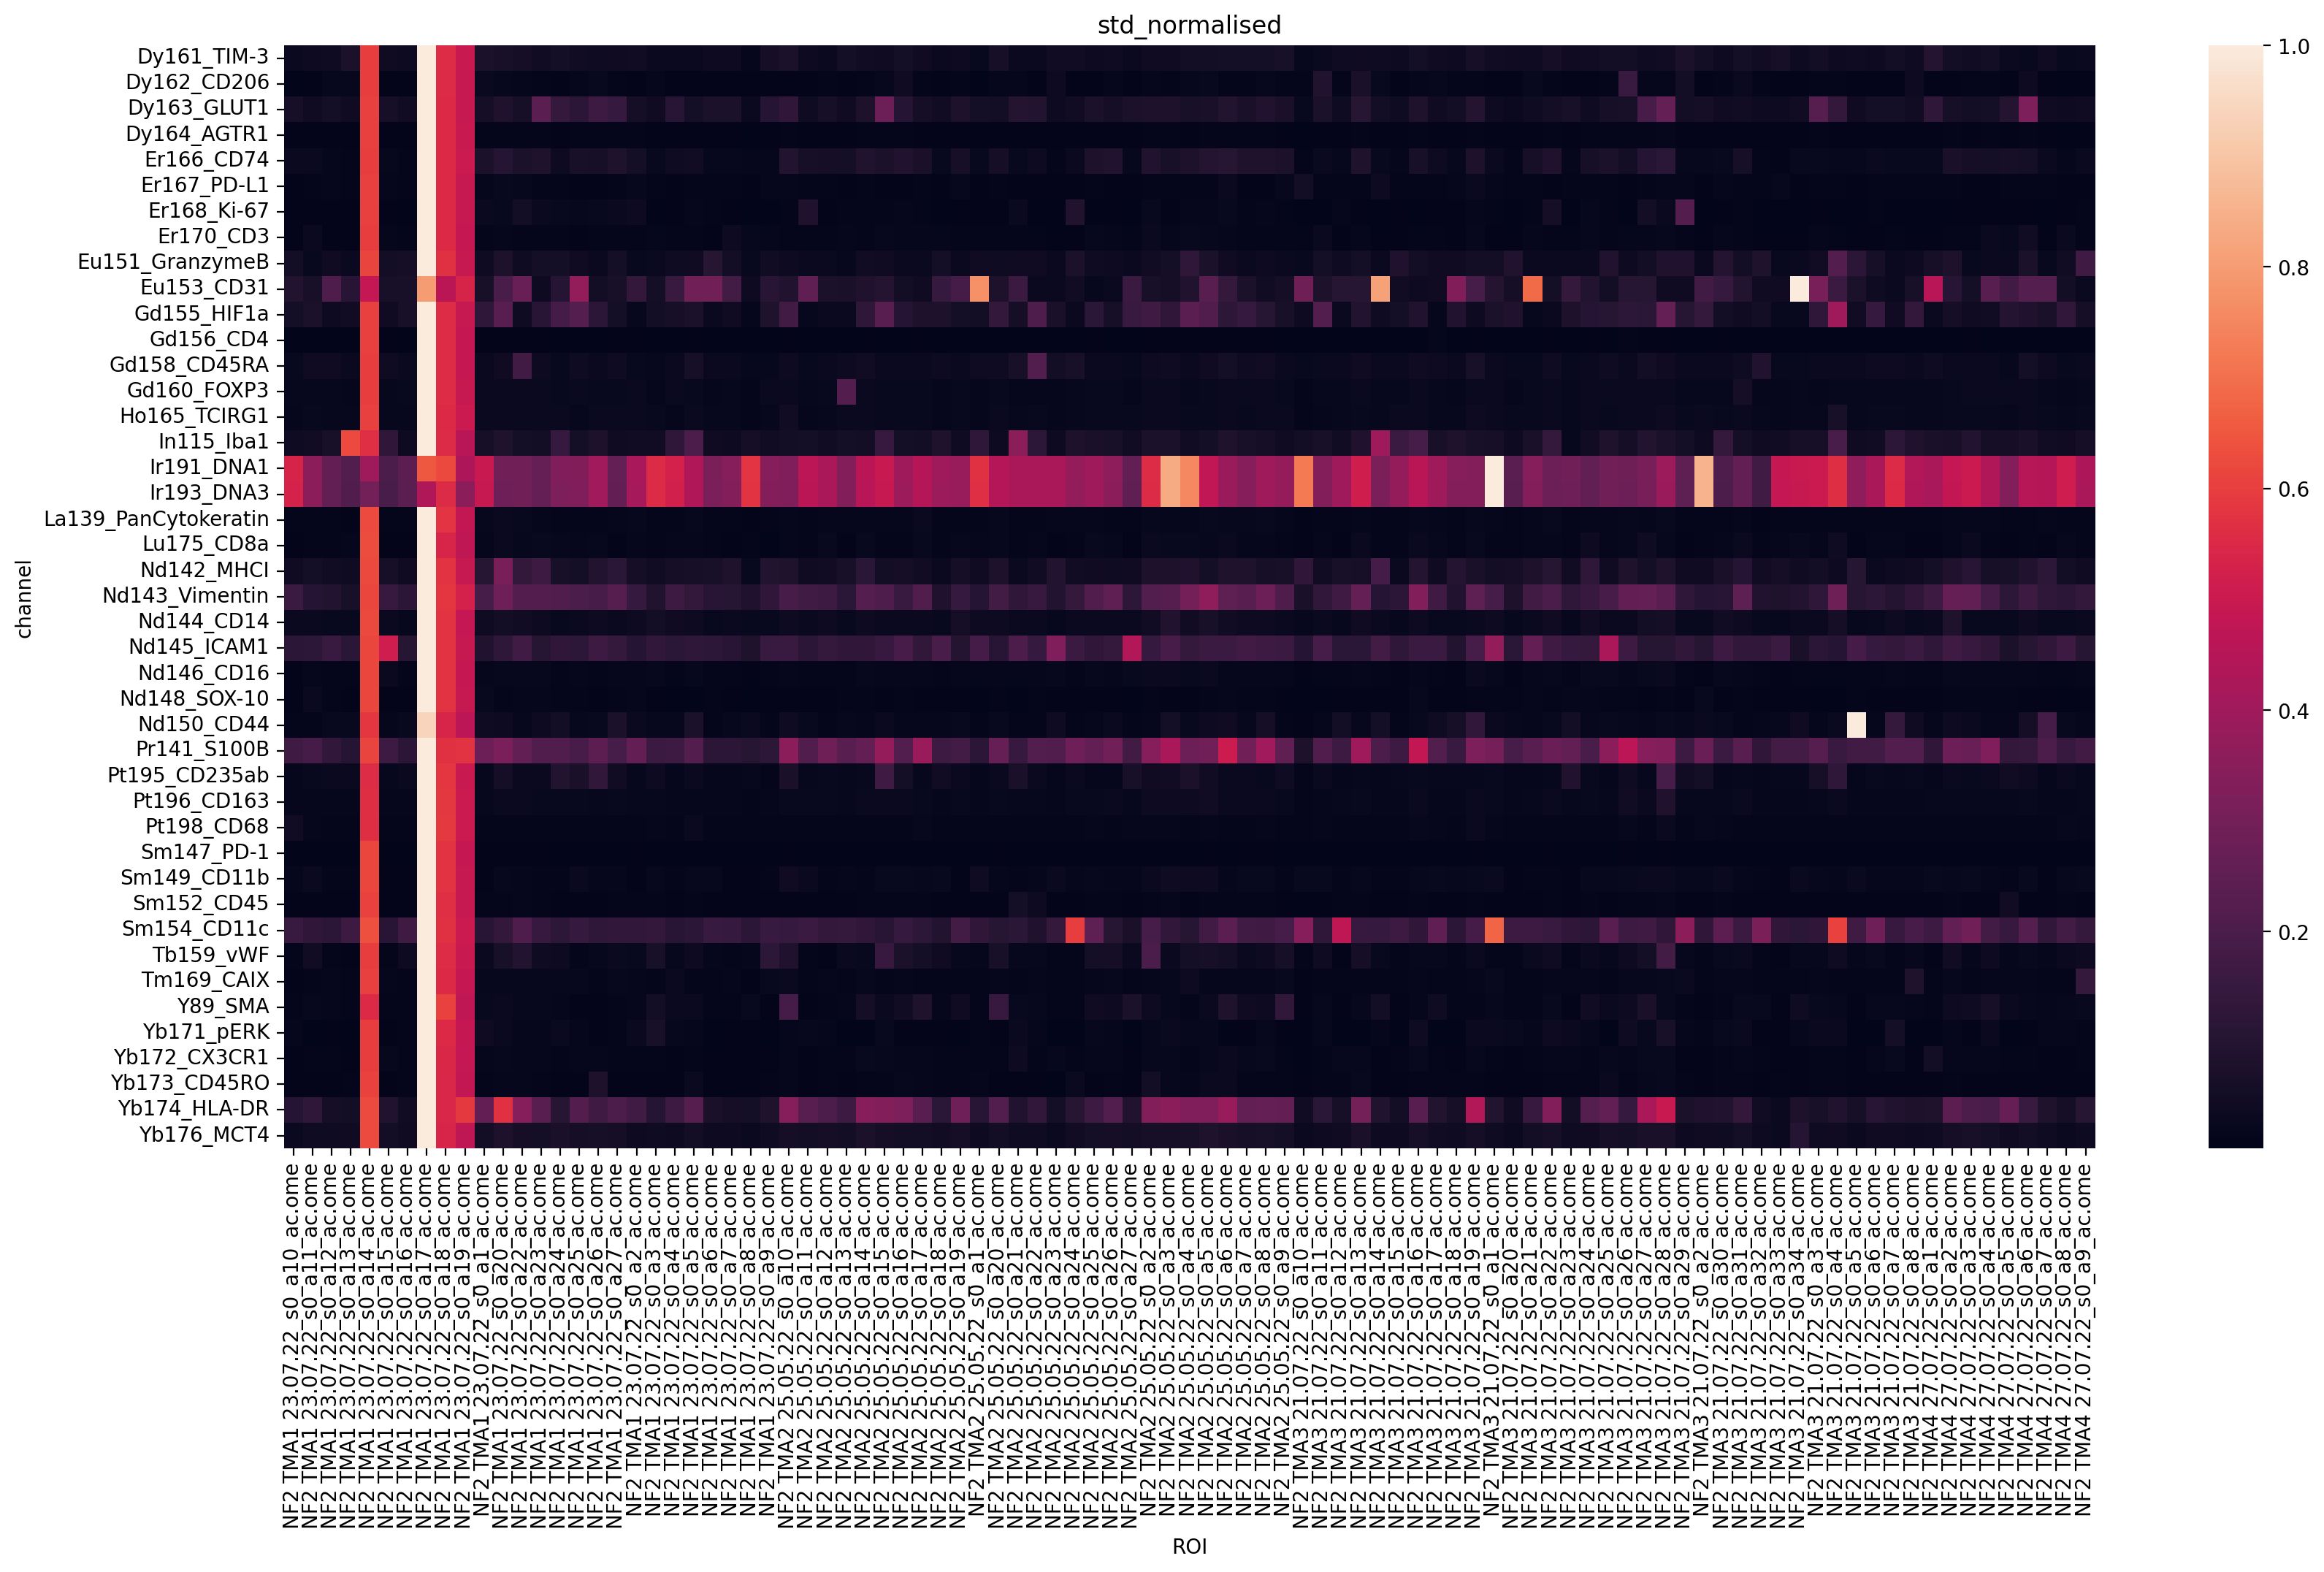

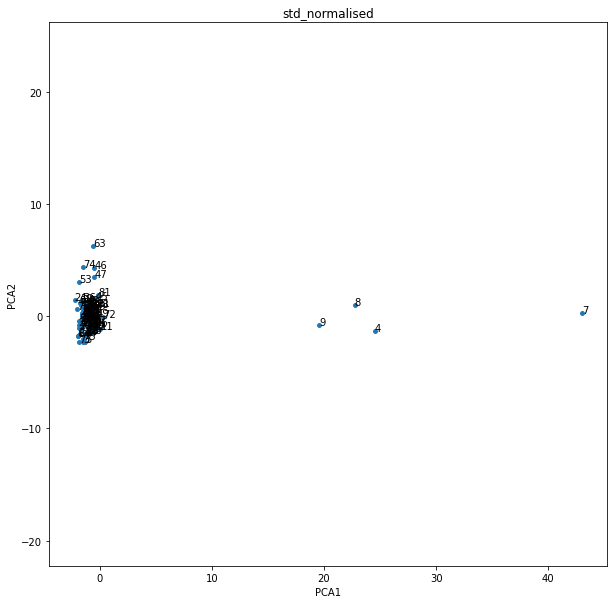

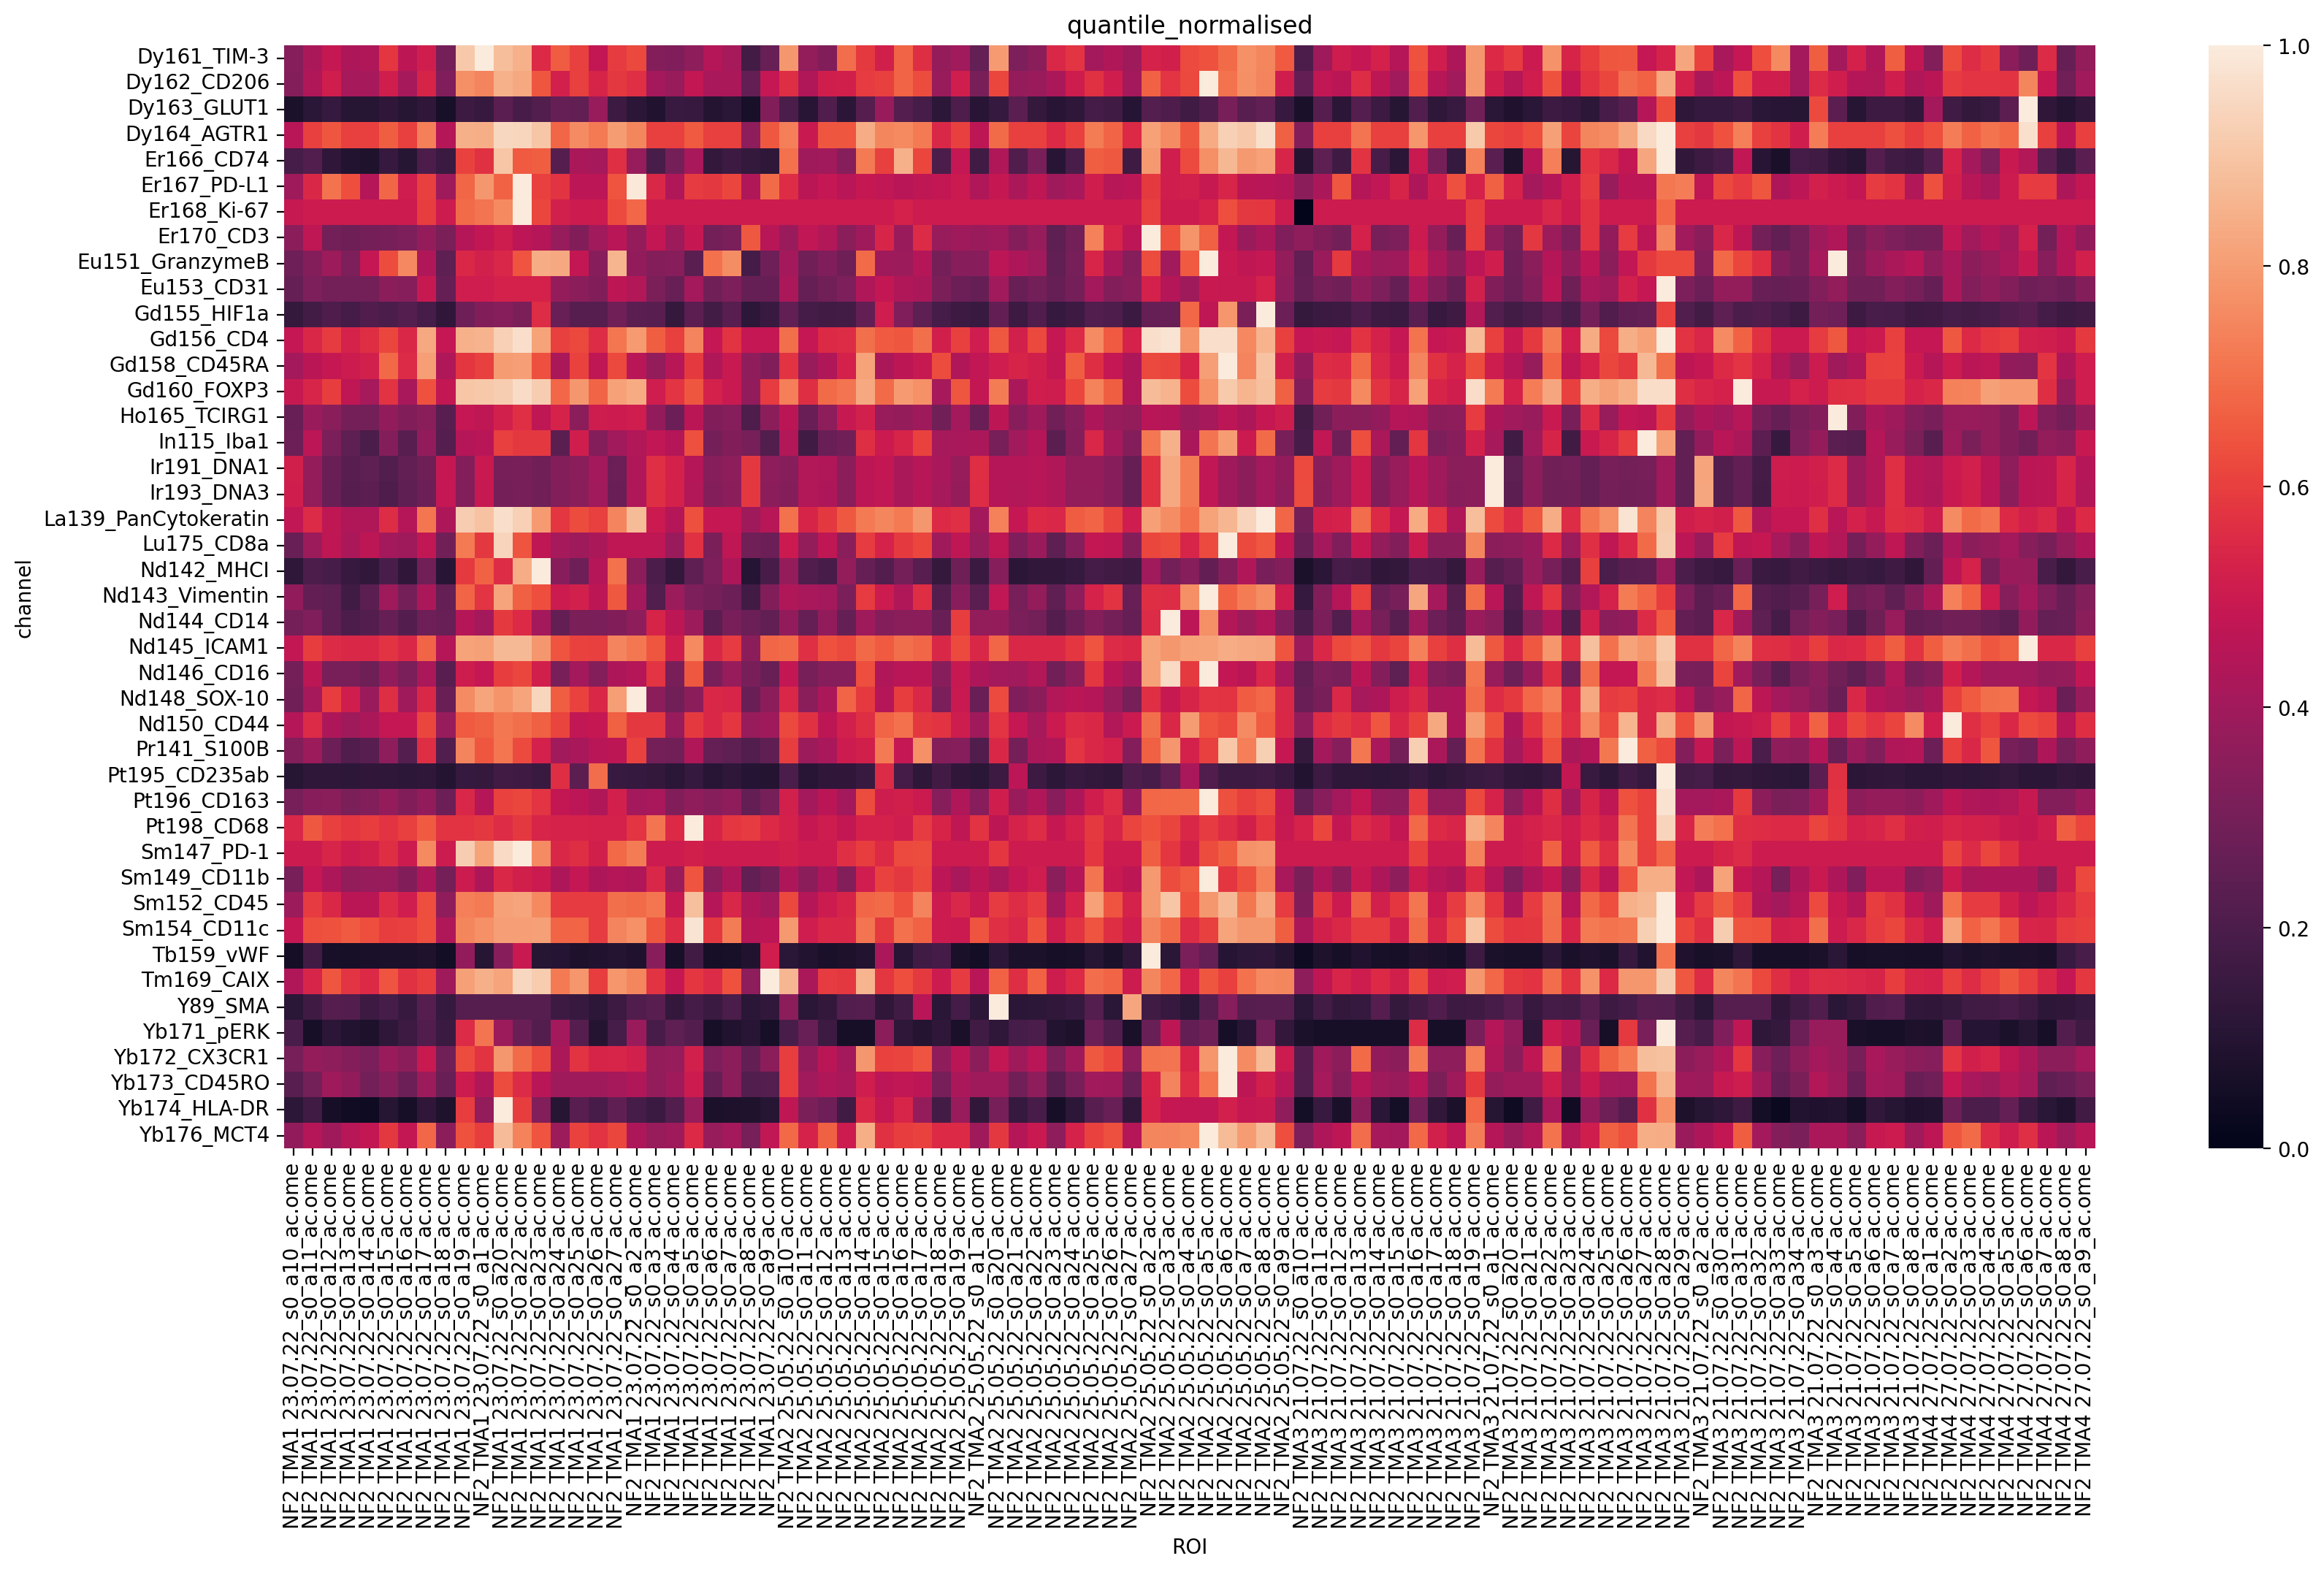

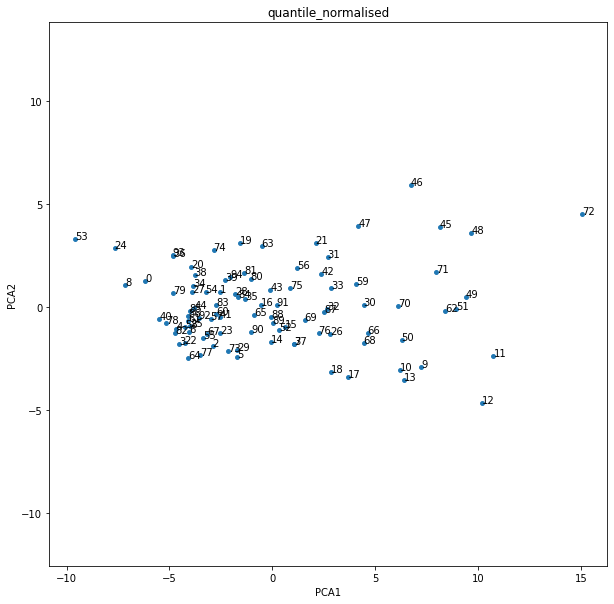

In [206]:
qc_heatmap()

## 3. Run DeepSNF training and image denoising


<font color='red'>raw_directory </font> = This should be the same as **'unstacked_output_folder'** above - where the unstacked images were stored, with each ROI being a folder containing all its images.

<font color='red'>processed_output_dir </font> = The folder where the processed images will be stored. They will be in the same format as above - each ROI its own folder containing all its images.

<font color='red'>process_all_channels </font> = If left as **True**, it will go through the channels identified above. Only works if you have panel files from the Bodenmiller pipeline, if not you will need to specify exactly which channels to process.

<font color='red'>specific_channels </font> = If process_all_channels is False, you specify exactly which channels to process here, e.g. if you only want to process a couple.

#### Deep SNF settings

These all have accompanying explanations, and can mostly be left alone. Ones you may want to change include...

<font color='red'>train_batch_size </font> If you are getting 'out of memory' errors you may need to reduce this to work on a GPU (e.g. to 32), or increase if you have a very good GPU setup.

<font color='red'>patch_step_size </font> This is the frequency (in pixels) at which patches are taken from the dataset for training. If you are getting errors of being out of memory, usually because you have a huge dataset, increase this from its default of 60, to 100-150.


In [ ]:
deep_SNF_batch(patch_step_size=150, train_batch_size=192)


Performing denoising on the following 43 channels... 

['Y89_SMA', 'In115_Iba1', 'La139_PanCytokeratin', 'Pr141_S100B', 'Nd142_MHCI', 'Nd143_Vimentin', 'Nd144_CD14', 'Nd145_ICAM1', 'Nd146_CD16', 'Sm147_PD-1', 'Nd148_SOX-10', 'Sm149_CD11b', 'Nd150_CD44', 'Eu151_GranzymeB', 'Sm152_CD45', 'Eu153_CD31', 'Sm154_CD11c', 'Gd155_HIF1a', 'Gd156_CD4', 'Gd158_CD45RA', 'Tb159_vWF', 'Gd160_FOXP3', 'Dy161_TIM-3', 'Dy162_CD206', 'Dy163_GLUT1', 'Dy164_AGTR1', 'Ho165_TCIRG1', 'Er166_CD74', 'Er167_PD-L1', 'Er168_Ki-67', 'Tm169_CAIX', 'Er170_CD3', 'Yb171_pERK', 'Yb172_CX3CR1', 'Yb173_CD45RO', 'Yb174_HLA-DR', 'Lu175_CD8a', 'Yb176_MCT4', 'Ir191_DNA1', 'Ir193_DNA3', 'Pt195_CD235ab', 'Pt196_CD163', 'Pt198_CD68']


  0%|                                                                                           | 0/43 [00:00<?, ?it/s]

Image data loaded from ...

tiffs\NF2 TMA1 23.07.22_s0_a10_ac.ome\01_00_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a11_ac.ome\01_01_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a12_ac.ome\01_02_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a13_ac.ome\01_03_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a14_ac.ome\01_04_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a15_ac.ome\01_05_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a16_ac.ome\01_06_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a17_ac.ome\01_07_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a18_ac.ome\01_08_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a19_ac.ome\01_09_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a1_ac.ome\01_10_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a20_ac.ome\01_11_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a22_ac.ome\01_12_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a23_ac.ome\01_13_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a24_ac.ome\01_14_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a25_ac.ome\01_15_Y89_SMA.tiff
tiffs\NF2 TMA1 23.07.22_s0_a26_ac.ome\01_16_Y89_SMA.tiff
tiff

273/273 [==============================] - 106s 386ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 0.0010
Epoch 9/50
273/273 [==============================] - ETA: 0s - loss: 0.0025
Epoch 9: saving model to C:\Users\Group\python\IMC_Denoise\trained_weights\weights_Y89_SMA.hdf5
273/273 [==============================] - 105s 386ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 0.0010
Epoch 10/50
273/273 [==============================] - ETA: 0s - loss: 0.0025
Epoch 10: saving model to C:\Users\Group\python\IMC_Denoise\trained_weights\weights_Y89_SMA.hdf5
273/273 [==============================] - 105s 385ms/step - loss: 0.0025 - val_loss: 0.0026 - lr: 0.0010
Epoch 11/50
273/273 [==============================] - ETA: 0s - loss: 0.0025
Epoch 11: saving model to C:\Users\Group\python\IMC_Denoise\trained_weights\weights_Y89_SMA.hdf5
273/273 [==============================] - 105s 385ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 0.0010
Epoch 12/50
273/273 [==============================] 

273/273 [==============================] - 105s 384ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 6.0000e-04
Epoch 38/50
273/273 [==============================] - ETA: 0s - loss: 0.0025
Epoch 38: saving model to C:\Users\Group\python\IMC_Denoise\trained_weights\weights_Y89_SMA.hdf5
273/273 [==============================] - 105s 384ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 6.0000e-04
Epoch 39/50
273/273 [==============================] - ETA: 0s - loss: 0.0025
Epoch 39: saving model to C:\Users\Group\python\IMC_Denoise\trained_weights\weights_Y89_SMA.hdf5
273/273 [==============================] - 105s 385ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 6.0000e-04
Epoch 40/50
273/273 [==============================] - ETA: 0s - loss: 0.0025
Epoch 40: saving model to C:\Users\Group\python\IMC_Denoise\trained_weights\weights_Y89_SMA.hdf5
273/273 [==============================] - 105s 385ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 6.0000e-04
Epoch 41/50
273/273 [==============

  2%|█▊                                                                          | 1/43 [1:30:40<63:28:36, 5440.86s/it]

Image data loaded from ...

tiffs\NF2 TMA1 23.07.22_s0_a10_ac.ome\05_00_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a11_ac.ome\05_01_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a12_ac.ome\05_02_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a13_ac.ome\05_03_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a14_ac.ome\05_04_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a15_ac.ome\05_05_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a16_ac.ome\05_06_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a17_ac.ome\05_07_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a18_ac.ome\05_08_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a19_ac.ome\05_09_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a1_ac.ome\05_10_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a20_ac.ome\05_11_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a22_ac.ome\05_12_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a23_ac.ome\05_13_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a24_ac.ome\05_14_In115_Iba1.tiff
tiffs\NF2 TMA1 23.07.22_s0_a25_ac.ome\05_15_In115_Iba1.tiff
tiffs\NF2 TMA

## 4. Side-by-side comparisson to check performance of denoising
At this stage, you can check that the before and afters for the denoising for each channel

<font color='red'>channels </font> List of channels you want to compare before and after denoising, by default it will do all of them

<font color='red'>colourmap </font> Colourmap for images

<font color='red'>dpi </font> Resolution of generated images

<font color='red'>save </font> Save images (or not). Will be saved as channel.png

<font color='red'>do_all_channels </font> Will process for all channels with data as identified above

<font color='red'>hide_images </font> Will hide images (just saving them instead)

By default, it will look for the raw and processed images in the directories specified above, but you can point to specific directories insteead (*raw_directory* and *processed_output_dir*)

In [ ]:
qc_check_side_by_side()

## 5. QC check on processed data
This will create heatmaps and PCAs that can be compared with those generated in step 2 on the raw data

In [ ]:
qc_heatmap(directory='processed')

## 6. Manually recombine

## 3. Reassemble TIFF stacks

At this point, we want to reassemble the invidiual images back into stacks so we can put them back into the Bodenmiller pipeline, replacing the ones originally generated. You may want to keep backups of the unprocessed tiffs!

<font color='red'> **By default, this pipeline will use all the processed image! If you only want to use some of the images, then manually assemble the individual TIFFs in the folders ready to be restacked**</font>


<font color='red'>restack_input_folder </font> = This should be the same as processed output directory above - where the processed images were stored, with each ROI being a folder containing all its images. Default is **'tiffs'**. 

<font color='red'>restack_input_folder </font> = Where the processed and now restacked images should be place. Default is **'tiffs_restacked'**. 

In [ ]:
reassemble_stacks()